### Transformer架构组装  
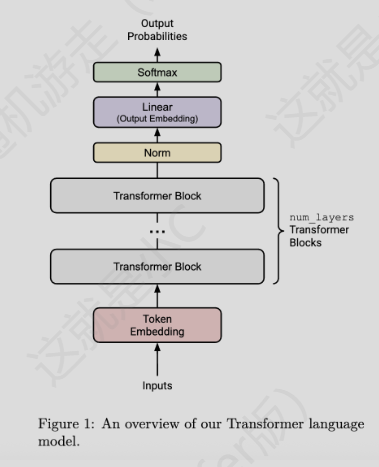

In [ ]:
import os
import math
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken

# -------------------------- 环境配置与超参数 --------------------------
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 超参数
batch_size = 4
context_length = 64
d_model = 128
num_blocks = 6
num_heads = 8
learning_rate = 1e-3
max_iters = 1000
eval_interval = 100

# -------------------------- LLM 组件 --------------------------

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    def forward(self, x):
        norm_x = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)
        return norm_x * self.weight

class SwiGLU(nn.Module):
    def __init__(self, d_model: int):
        super().__init__()
        hidden_dim = int(8/3 * d_model)
        self.w1 = nn.Linear(d_model, hidden_dim, bias=False)
        self.w2 = nn.Linear(d_model, hidden_dim, bias=False)
        self.w3 = nn.Linear(hidden_dim, d_model, bias=False)
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

def precompute_rope_freqs(dim: int, seq_len: int, theta: float = 10000.0):
    # dim 应该是 head_dim (16)
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2).float() / dim))
    t = torch.arange(seq_len).float()
    freqs = torch.outer(t, freqs) # 得到 (seq_len, dim//2) 即 (64, 8)
    return torch.cos(freqs), torch.sin(freqs)

def apply_rope(x, cos, sin):
    # x shape: (B, T, n_heads, head_dim) -> (4, 64, 8, 16)
    # cos/sin shape: (T, head_dim) -> (64, 16)
    B, T, H, D = x.shape
    
    # 将 cos/sin 调整为 (1, T, 1, D) 方便与 x 广播相乘
    cos = cos[:T, None, :]
    sin = sin[:T, None, :]
    
    # 旋转逻辑: [x1, x2] -> [-x2, x1]
    x1 = x[..., :D//2]
    x2 = x[..., D//2:]
    rotated_x = torch.cat([-x2, x1], dim=-1)
    
    # RoPE 公式: x*cos + rotated_x*sin
    return (x * cos) + (rotated_x * sin)

# -------------------------- 模型主体 --------------------------

class ModernAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.n_heads = num_heads
        self.head_dim = d_model // num_heads # 128 // 8 = 16
        self.wqkv = nn.Linear(d_model, 3 * d_model, bias=False)
        self.wo = nn.Linear(d_model, d_model, bias=False)
        self.register_buffer("mask", torch.tril(torch.ones(context_length, context_length)))

    def forward(self, x, cos, sin):
        B, T, C = x.shape
        qkv = self.wqkv(x).reshape(B, T, 3, self.n_heads, self.head_dim)
        q, k, v = qkv.unbind(2)

        # 应用旋转位置编码
        q = apply_rope(q, cos, sin)
        k = apply_rope(k, cos, sin)

        # 注意力计算
        scores = (q.transpose(1, 2) @ k.transpose(1, 2).transpose(-2, -1)) / math.sqrt(self.head_dim)
        scores = scores.masked_fill(self.mask[:T, :T] == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        out = (attn @ v.transpose(1, 2)).transpose(1, 2).reshape(B, T, C)
        return self.wo(out)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.attn = ModernAttention(d_model, num_heads)
        self.ffn = SwiGLU(d_model)
        self.norm1 = RMSNorm(d_model)
        self.norm2 = RMSNorm(d_model)

    def forward(self, x, cos, sin):
        x = x + self.attn(self.norm1(x), cos, sin)
        x = x + self.ffn(self.norm2(x))
        return x

class LlamaTiny(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, num_heads) for _ in range(num_blocks)])
        self.final_norm = RMSNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size, bias=False)
        
        #  RoPE 预计算逻辑
        head_dim = d_model // num_heads # 16
        c, s = precompute_rope_freqs(head_dim, context_length)
        # 将频率猫合 (T, 8) -> (T, 16)，确保与 head_dim 匹配
        self.register_buffer("cos", torch.cat([c, c], dim=-1))
        self.register_buffer("sin", torch.cat([s, s], dim=-1))

    def forward(self, idx, targets=None):
        if (idx >= self.vocab_size).any():
            raise IndexError(f"Token索引越界,词表上限{self.vocab_size}, 收到{idx.max().item()}")
            
        x = self.token_emb(idx)
        for block in self.blocks:
            x = block(x, self.cos, self.sin)
        x = self.final_norm(x)
        logits = self.output(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))
        return logits, loss

    def generate(self, idx, max_new_tokens):
        self.eval()
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:]
            logits, _ = self(idx_cond)
            probs = F.softmax(logits[:, -1, :], dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        self.train()
        return idx

# -------------------------- 数据流与训练 --------------------------
VOCAB_LIMIT = 10000 
encoding = tiktoken.get_encoding("cl100k_base")

try:
    with open(r'C:\Users\23017\Desktop\LLM\cs336\Lecture 2 Transformer\sales_textbook.txt', 'r', encoding='utf-8') as f:
        text = f.read()
except FileNotFoundError:
    text = "The salesperson is helping the customer identify their needs." * 200

raw_tokens = encoding.encode(text)
tokens = [t for t in raw_tokens if t < VOCAB_LIMIT]
data = torch.tensor(tokens, dtype=torch.long, device=device)

n = int(0.9 * len(data))
train_data, val_data = data[:n], data[n:]

def get_batch(split):
    ds = train_data if split == 'train' else val_data
    # 增加安全性检查，防止样本过短
    max_idx = len(ds) - context_length
    if max_idx <= 0: return get_batch('train') 
    ix = torch.randint(max_idx, (batch_size,))
    x = torch.stack([ds[i : i+context_length] for i in ix])
    y = torch.stack([ds[i+1 : i+context_length+1] for i in ix])
    return x.to(device), y.to(device)

# 运行
model = LlamaTiny(VOCAB_LIMIT).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

print(f"模型开始在 {device} 上训练...")
for step in range(max_iters):
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    if step % eval_interval == 0:
        print(f"Step {step:4d} | Loss: {loss.item():.4f}")

# 生成测试
model.eval()
test_in = torch.tensor([encoding.encode("The salesperson")[:5]], device=device)
generated = model.generate(test_in, 50)
print("\n 生成内容:\n" + "-"*30)
print(encoding.decode(generated[0].tolist()))
print("-"*30)

模型开始在 cuda 上训练...
Step    0 | Loss: 9.3971
Step  100 | Loss: 4.2822
Step  200 | Loss: 3.8583
Step  300 | Loss: 3.9073
Step  400 | Loss: 3.4875
Step  500 | Loss: 3.0137
Step  600 | Loss: 2.8412
Step  700 | Loss: 2.5077
Step  800 | Loss: 2.1217
Step  900 | Loss: 3.0307

 生成内容:
------------------------------
The salesperson the value and benefits of their. This that the solution to the they will be, research and the key benefits they will have from and validate your solution. those, you can be done your full of the value of your. By the effective, you
------------------------------
